<a href="https://colab.research.google.com/github/atursky/AU-ML/blob/main/principal_component_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction #

In this lesson we look at principal component analysis (PCA). Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

(Technical note: PCA is typically applied to standardized data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data in this course will be standardized before applying PCA.)

# Principal Component Analysis #

In the [*Abalone*](https://www.kaggle.com/rodolfomendes/abalone-dataset) dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the `'Height'` and `'Diameter'` of their shells.

You could imagine that within this data are "axes of variation" that describe the ways the abalone tend to differ from one another. Pictorially, these axes appear as perpendicular lines running along the natural dimensions of the data, one axis for each original feature.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/rr8NCDy.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

Often, we can give names to these axes of variation. The longer axis we might call the "Size" component: small height and small diameter (lower left) contrasted with large height and large diameter (upper right). The shorter axis we might call the "Shape" component: small height and large diameter (flat shape) contrasted with large height and small diameter (round shape).

Notice that instead of describing abalones by their `'Height'` and `'Diameter'`, we could just as well describe them by their `'Size'` and `'Shape'`. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/XQlRD1q.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>The principal components become the new features by a rotation of the dataset in the feature space.
</center></figcaption>
</figure>

The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

```
df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
```

These new features are called the **principal components** of the data. The weights themselves are called **loadings**. There will be as many principal components as there are features in the original dataset: if we had used ten features instead of two, we would have ended up with ten components.

A component's loadings tell us what variation it expresses through signs and magnitudes:

| Features \ Components | Size (PC1) | Shape (PC2) |
|-----------------------|------------|-------------|
| Height                | 0.707      | 0.707       |
| Diameter              | 0.707      | -0.707      |

This table of loadings is telling us that in the `Size` component, `Height` and `Diameter` vary in the same direction (same sign), but in the `Shape` component they vary in opposite directions (opposite sign). In each component, the loadings are all of the same magnitude and so the features contribute equally in both.

PCA also tells us the *amount* of variation in each component. We can see from the figures that there is more variation in the data along the `Size` component than along the `Shape` component. PCA makes this precise through each component's **percent of explained variance**.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/xWTvqDA.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center> Size accounts for about 96% and the Shape for about 4% of the variance between Height and Diameter.
</center></figcaption>
</figure>

The `Size` component captures the majority of the variation between `Height` and `Diameter`. It's important to remember, however, that the amount of variance in a component doesn't necessarily correspond to how good it is as a predictor: it depends on what you're trying to predict.

# PCA for Feature Engineering #

There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of `'Height'` and `'Diameter'` if `'Size'` is important, say, or a ratio of `'Height'` and `'Diameter'` if `Shape` is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:
- **Dimensionality reduction**: When your features are highly redundant (*multicollinear*, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- **Anomaly detection**: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- **Noise reduction**: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- **Decorrelation**: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!

# PCA Best Practices #
There are a few things to keep in mind when applying PCA:
* PCA only works with numeric features, like continuous quantities or counts.
* PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
* Consider removing or constraining outliers, since they can have an undue influence on the results.

# Example - 1985 Automobiles #

In this example, we will use the *Automobile* (https://www.kaggle.com/toramky/automobile-dataset) dataset and apply PCA, using it as a descriptive technique to discover features. We'll look at other use-cases in the exercise.

This hidden cell loads the data and defines the functions `plot_variance` and `make_mi_scores`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, height=4, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, figheight=height, dpi=100)
    return axs


df = pd.read_csv("https://raw.githubusercontent.com/rushabh-mehta/EDA-on-Automobile-Dataset/master/Automobile_data.csv")

We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, `price`. We'll standardize the data since these features aren't naturally on the same scale.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [ ]:
df["horsepower"].replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df.index = range(df.shape[0])

In [ ]:
features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]
X["horsepower"] = X["horsepower"].astype(int)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   highway-mpg  203 non-null    int64
 1   engine-size  203 non-null    int64
 2   horsepower   203 non-null    int64
 3   curb-weight  203 non-null    int64
dtypes: int64(4)
memory usage: 6.5 KB


In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(X)

In [ ]:
X_scaled = pd.DataFrame(df_scaled, columns=X.columns)

Now we can fit scikit-learn's `PCA` estimator and create the principal components. You can see here the first few rows of the transformed dataset.

In [ ]:
X_scaled

,highway-mpg,engine-size,horsepower,curb-weight
0,-0.543037,0.075292,0.170228,-0.015177
1,-0.543037,0.075292,0.170228,-0.015177
2,-0.687894,0.602339,1.255637,0.511728
3,-0.108465,-0.427798,-0.056950,-0.419457
4,-1.267324,0.219032,0.271197,0.513644
...,...,...,...,...
198,-0.398180,0.338816,0.245955,0.758895
199,-0.832752,0.338816,1.407089,0.944749
200,-1.122467,1.105429,0.750796,0.873856
201,-0.543037,0.434642,0.044018,1.266640


In [ ]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()

X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

After fitting, the `PCA` instance contains the loadings in its `components_` attribute. (Terminology for PCA is inconsistent, unfortunately. We're following the convention that calls the transformed columns in `X_pca` the *components*, which otherwise don't have a name.) We'll wrap the loadings up in a dataframe.

In [ ]:
pca.components_

array([[-0.48636693,  0.5020525 ,  0.50027261,  0.51099687],
       [ 0.77475153,  0.62485679,  0.03380273,  0.09039592],
       [ 0.08872308, -0.06293488,  0.77951083, -0.61687136],
       [ 0.39412622, -0.59458933,  0.37542982,  0.59176051]])

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway-mpg,-0.486367,0.774752,0.088723,0.394126
engine-size,0.502053,0.624857,-0.062935,-0.594589
horsepower,0.500273,0.033803,0.779511,0.375430
curb-weight,0.510997,0.090396,-0.616871,0.591761


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (`PC1`) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

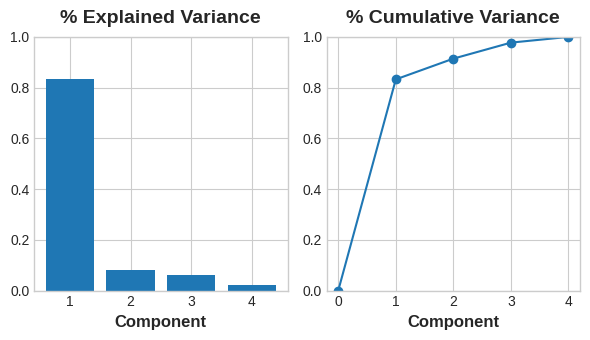

In [ ]:
# Look at explained variance
plot_variance(pca, width=6, height=3.5);

The third component shows a contrast between `horsepower` and `curb_weight` -- sports cars vs. wagons, it seems.

In [ ]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body-style", "horsepower", "curb-weight"]
df.loc[idx, cols]

,make,body-style,horsepower,curb-weight
129,porsche,hatchback,288,3366
126,porsche,hardtop,207,2756
127,porsche,hardtop,207,2756
128,porsche,convertible,207,2800
105,nissan,hatchback,200,3139
...,...,...,...,...
68,mercedes-benz,wagon,123,3750
70,mercedes-benz,sedan,123,3770
110,peugot,wagon,95,3430
114,peugot,wagon,95,3485
